# Data Analysis for the Single Slit Diffraction Experiment
1. **Import Data:** Save data taken from the Raspberry Pi to the folder named "Files", make sure and copy the filename including the .csv at the end. In the cell below paste the file name after the 'Files/' in the line that begins with "array = "

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
from datetime import date

#set your file to pull data from
h5Name = "Files/EDPH2024-10-25_09188-dataset.hdf5"
#imports values from file into a numpy array
with h5py.File(h5Name,"r") as fi:
    total = fi['Average'][:]

2. **Select the Data:** In the cell below you will select the horizontal row of pixels you want to read the values of. 
    - First change the initials to yours to help you find the data that is saved
    - Run the cell, and in the text box that shows up input an inital guess of what numbered row you would like to take data of. You will get to change this row before you save data. 1500 is a good inital guess.
    - Next use the axes marked to refine your guesses until the red line covers the part of the picture you would like to take data of.
    - Enter save into the input box when you have the line where you want it. 
    - Enter break into the input box to leave the loop.

An error occurred: name 'os' is not defined
to exit, input: break
to save data, input: save
1600.0


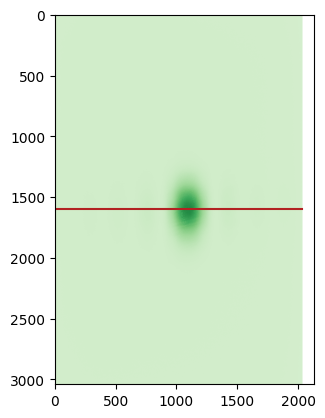

Image Saved As:  Data/AF20241030_194652-ImageWithLine.jpg
Program Stopping...
Program Stopped


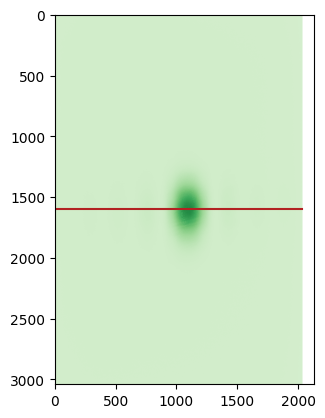

In [2]:
MYINITIALS = 'AF'

folderName = str(date.today())
folderMade = True
try:
	os.mkdir('Data/'+folderName)
	print(f"Folder '{folderName}' created to save to.")
except FileExistsError:
	print(f"Saving to '{folderName}'")
except PermissionError:
	print(f"Permission denied: Unable to create '{folderName}'.")
	folderMade = False
except Exception as e:
	print(f"An error occurred: {e}")
	folderMade = False


#Here is the filename construction based upon date and time.
ddtt = datetime.datetime.now()
nameformat="%Y%m%d_%H%M%S"

if folderMade:
    myrootfilename = (
        'Data/' + folderName + '/' +
        MYINITIALS + 
        ddtt.strftime(nameformat)
    )
else:
    myrootfilename = 'Data/' + MYINITIALS + ddtt.strftime(nameformat)

csvname2 = myrootfilename+'-curve.csv'
imagename = myrootfilename+'-ImageWithLine.jpg'


#finds the width of the array of pixels, and sets the line we graph to the full width
a1,b1 = total.shape
nums = np.array([1,b1])

print("to exit, input: break") #prints the exit instructions
print("to save data, input: save") #prints the save instructions

while(True): #loop until break is entered
    
    #input that asks for the y value you would like to graph the line at
    value = input("enter y-axis value, positive whole numbers only:")
    
    #checks to see if break was entered, then stops the loop
    if(value=="break"):
        print("Program Stopping...")
        break
        
    #checks to see if the input is a positive number, then graphs a line at that y value
    elif(value.isdigit()):
        intvalue = float(value) #saves the value as a float
        print(intvalue) # Makes it easier to use same value when re-running code
        ynums = np.array([intvalue,intvalue]) #creates an array to graph
        plt.figure()
        plt.imshow(total,cmap='Greens') #this line graphs the picture to the plt figure
        plt.plot(nums,ynums,color="firebrick") #graphs the line at the input y-value
        plt.show()
        
    elif(value=="save"):
        #grn3 = pd.DataFrame(total)
        #grn3.to_csv(csvname1,index=False)
        plt.figure()
        plt.imshow(total,cmap='Greens') #this line graphs the picture to the plt figure
        plt.plot(nums,ynums,color="firebrick")        
        plt.savefig(imagename)
        print("Image Saved As: ",imagename)
        print("Program Stopping...")
        break

    #prints an "error" message
    else:
        print("entered value not a positive number")

print("Program Stopped")

3. **Graph your Data:** The data you selected is now saved to the Data folder. The file names were given to you as outputs as well. The next cell will graph and save the specific line of data you selected with your red line. Simply run it and note the file name, that file is also saved to the Data folder.

Pixel Row:  1600


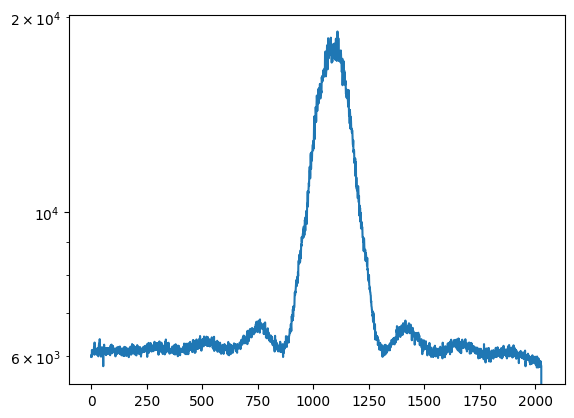

Curve Already Saved
Data Saved As:  Data/AF20241030_194652-curve.csv


In [3]:
intvalue=int(intvalue) #converts the input value to an int

print("Pixel Row: ",intvalue) #outputs the value that was input

data = np.array(total[intvalue][:]) #collects the row of data points at the input y-value

plt.figure()
plt.yscale("log")
plt.plot(data)
plt.show()

with h5py.File(h5Name,"a") as fi:
    try:
        fi["Curve"] = data
    except:
        print("Curve Already Saved")
        
np.savetxt(csvname2, data, delimiter=",")
print("Data Saved As: ",csvname2)

In [4]:
with h5py.File(h5Name,"r") as fi:
    print(list(fi.keys()))
    std = fi['Standard Deviation'][:]
    curve = fi['Curve'][:]
    average = fi['Average'][:]

['Average', 'Curve', 'Standard Deviation', 'run0', 'run1', 'run10', 'run11', 'run12', 'run13', 'run14', 'run15', 'run16', 'run17', 'run18', 'run19', 'run2', 'run3', 'run4', 'run5', 'run6', 'run7', 'run8', 'run9']


# Plot the average data

The data consists, in this run, of 20 separate groups whose values are averaged out to create the "Average" data group in the HDF5 file. Plot the average data instead of a specific run for better, more statistically accurate results.

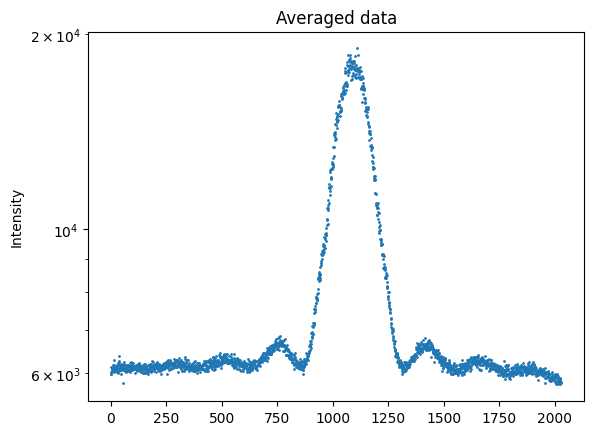

In [64]:
avg = np.array(average[intvalue][:])
x = np.arange(len(avg))
plt.scatter(x, avg, s=1)
plt.title('Averaged data')
plt.ylabel('Intensity')
plt.yscale('log')
plt.show()

# Using a Gaussian to find the max intensity

The max intensity will be needed to create a shape that can fit over our data. By isolating the largest central peak and doing Gaussian analysis, we should be able to find the value of the max intensity and point on the sensor on which the max intensity occurs. 

The equation for the gaussian goes as:

$$f(x) = A exp[-\frac{(x-B)^2}{2C^2}] + D$$

With the variables defined as:

$A:$ The ampltidue of the curve. This corresponds to the maximum luminosity

$B:$ Also $\mu$. This corresponds to the pixels that are at the center of the curve,

$C:$ The standard deviation/thickness of the line, also $\sigma$. This corresponds to the uncertainty in our data.

$D:$ And, the height above the $y$ axis, or the y offset

In [6]:
# Creating the gaussian equations
from scipy.optimize import curve_fit

# Defining the gaussian
def gaussian(x, amplitude, mu, sigma, y_offset):
    return amplitude * np.exp(-((x - mu)**2) / (2 * sigma**2)) + y_offset

def find_values(A, B, C, D, xdata, ydata):
    # popt = parameters optimized
    # pcov = Covariance, variance = error squared
    popt, pcov = curve_fit(gaussian, xdata, ydata, 
                          p0=[A, B, C, D]) 

    amplitude, mean, sigma, vertical_offset = popt
    sigma_amp, sigma_mean, sigma_std, sigma_b = np.sqrt(np.diag(pcov))

    return amplitude, mean, sigma, vertical_offset#, sigma_amp, sigma_mean, sigma_std, sigma_b

Plugging our data into this code allows us to find the value of the maximum brightness and the pixel number which would should be directly across from the laser ($y_{p}=0$)

Amplitude: 12222.15, Mean: 174.27, Sigma: 84.74, Vertical Offset: 5800.27


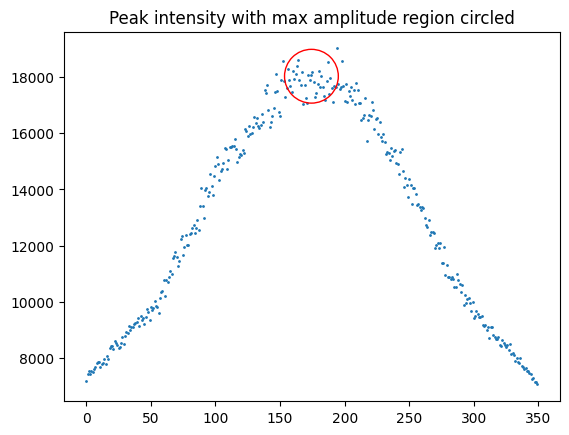

The vertical offset value, 5800.27, is likely a little small as it is only finding the value
around the max intensity peak.


In [67]:
# Finding the max intensity
# Grab the center peak
ydata = avg[915:1265]
xdata = np.arange(len(ydata))
amplitude, mean, sigma, vertical_offset = find_values(12000, 180, 50, 6000, xdata, ydata)
print(f'Amplitude: {amplitude:.2f}, Mean: {mean:.2f}, Sigma: {sigma:.2f}, Vertical Offset: {vertical_offset:.2f}')
# Plot the data
plt.scatter(xdata, ydata, s=1)

# Circle the maximum intensity area
center = (mean, amplitude+vertical_offset)
plt.scatter(mean, amplitude+vertical_offset, s=1500, facecolors='none',edgecolors='red',marker='o', linewidth=1)
plt.title('Peak intensity with max amplitude region circled')
plt.show()
# mean value here is offset by the slice. Return it to normal so it can be used
mean = 915 + mean

print(f'The vertical offset value, {vertical_offset:.2f}, is likely a little small as it is only finding the value\naround the max intensity peak.')

# Data Analysis
The light intensity across the detector should be given by the equation:
$$ I(y_{p}) = I_{max}[\frac{sin(\frac{\pi a}{\lambda}sin \theta)}{\frac{\pi a}{\lambda}sin \theta}]^{2} $$
Where $y_{p}$ are the observation points on a line across the detector screen. 

$I_{max}$ is the point directly across from the aperture (of width $a$) where $y_{p}=0$ and the distance from the aperture = $D$. 

$\lambda$ is the wavelength of light being put through the aperture. 

$\theta$ is the angle that $y_{p}$ subtends from the optix axis when seen from the aperture (with $D >> a$). 

As we're working with small angles, we can simplify $sin(\theta) \approx \frac{y_{p}}{D}$

If we plug in all of the parameters of the data which our group gathered, we should be able to create a graph which matches with the actual data taken by the Raspberry Pi sensor.

There is a discrepancy between the length of the data and the size of the sensor:
Data length = 2032
Number of pixels on sensor = 4072
Sensor width = 7.564 mm = 7.564e6 nm
Manufacture specified pixel width = 1.55 micrometers = 1550 nm
Total width across effective pixel is: 2879.22 nm


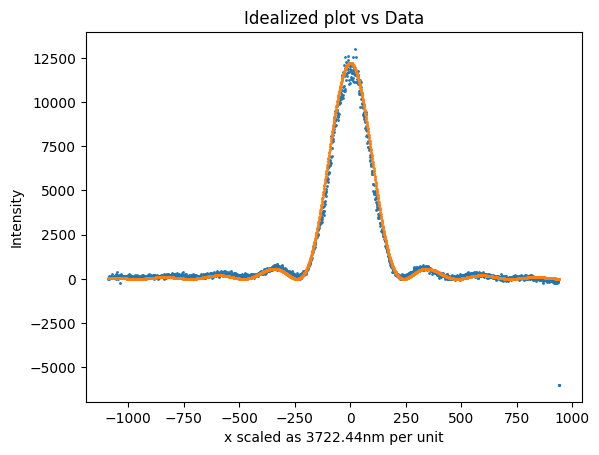

outlier data: -6000.266261690189


In [ ]:
from scipy.signal import find_peaks
imax = amplitude

# py sensor length = 7.564 mm
wavelength = 528 # nm
aperture   = 160000 # nm
distance   = 2.1e8 # nm
pixel_count = 4072
# Set the location of the maximum on the x axis to be the origin
x = np.arange(len(avg))
print(f'There is a discrepancy between the length of the data and the size of the sensor:')
print(f'Data length = {len(avg)}')
print(f'Number of pixels on sensor = {pixel_count}')
print('Sensor width = 7.564 mm = 7.564e6 nm')
print('Manufacture specified pixel width = 1.55 micrometers = 1550 nm')

pixel_width = (7.564e6/pixel_count) * 1.55 # Conversion factor 

print(f'Total width across effective pixel is: {pixel_width:.2f} nm')
y = avg
# Find the location of the maximum point using the gaussian from earlier
max_index = int(mean)
# Find the x-coordinate of the maximum
x_max = x[max_index]
# Shift x so that the maximum is at the origin
x_shifted = x - x_max
intensity_array = []
def intensity_function(aperture, wavelength, sin_theta):
    numerator = np.sin(np.pi * aperture * sin_theta / wavelength)
    denominator = (np.pi * aperture / wavelength) * sin_theta
    intensity = imax * (( numerator / denominator) ** 2)

    return intensity

for i in x_shifted:
    sin_theta = (i * pixel_width) / distance
    
    # Avoid division by zero at the origin
    if sin_theta == 0:
        intensity = imax  # Set to the maximum intensity when sin_theta is zero
    else:
        intensity = intensity_function(aperture, wavelength, sin_theta)
    intensity_array.append(intensity)

#Estimate extra background light intensity
fudge_factor = 200

# Conversion factor to scale x-axis
conversion_facotr = 7.564e6/len(avg) #nm per x value
plt.scatter(x_shifted, avg - vertical_offset - fudge_factor, s=1, label='Data')
plt.scatter(x_shifted, intensity_array, s=1, label='Ideal Plot')
plt.title('Idealized plot vs Data')
plt.ylabel('Intensity')
plt.xlabel(f'x scaled as {conversion_facotr:.2f}nm per unit')
plt.show()
print(f'outlier data: {min(avg - vertical_offset - fudge_factor)}')

# Showing that the minimums have a wavelike relationship

Using the equation from before which describes the intensity of light through a single slit:
$$I(y_{p}) = I_{max}[\frac{sin(\frac{\pi a}{\lambda}sin \theta)}{\frac{\pi a}{\lambda}sin \theta}]^{2}$$

We can show that this equation has zeroes at the points where $y_{p}=m \frac{\lambda D}{a}$ keeping in mind that $sin \theta \approx \frac{y_{p}}{D}$, so, $sin \theta \approx \frac{m \lambda}{a}$, otherwise described as the points where a wave which began from one side of the aperture would cancel out with a wave which began from the other side of the aperture. This behaviour makes the most sense following Huygens' principle that every point on a wave front acts as a new source for the same wave.

Index values (y_p) and m values for wavelength minima:
aperture: 160000, wavelength: 528
y = -963, sin theta: -0.02, m = -6.20
y = -722, sin theta: -0.02, m = -4.65
y = -481, sin theta: -0.01, m = -3.10
y = -241, sin theta: -0.01, m = -1.55
y = 241, sin theta: 0.01, m = 1.55
y = 481, sin theta: 0.01, m = 3.10
y = 722, sin theta: 0.02, m = 4.65


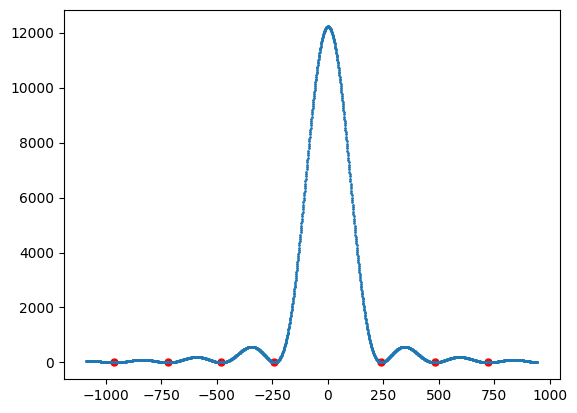

In [79]:
intensity_array = np.array(intensity_array)
# Find min values of intensities
min_indices, _ = find_peaks(-intensity_array)

#min_values = intensity_array[min_indices]
min_values = []
print('Index values (y_p) and m values for wavelength minima:')
print(f'aperture: {aperture}, wavelength: {wavelength}')
for index in min_indices:
    # Collect intensity value before adjusting for shifted x-axis
    value = intensity_array[index]
    min_values.append(value)

    # Shift x-axis so peak is at 0 again
    index = index - x_max
    sin_theta = (index * pixel_width * 1.55) / distance

    # Round m value to two decimals to avoid .99 values
    print(f'y = {index}, sin theta: {sin_theta:.2f}, m = {sin_theta * aperture / wavelength:.2f}')

    

# Plot the locations of the minimum values
plt.scatter(min_indices-x_max, min_values, s=25, color='r')
plt.scatter(x_shifted, intensity_array, s=1)
plt.show()